In [5]:
import sys
sys.path.append('../../')

import jax
import jax.numpy as np
import numpy as onp
import os
import matplotlib.pyplot as plt
from discretization2D import *
from solver import *
from plot import *

os.environ["CUDA_VISIBLE_DEVICES"]="1"
jax.config.update("jax_enable_x64", True)
%matplotlib notebook

In [6]:
### 2D box mesh
domain_x = 1.
domain_y = 1.
Nx = 128
Ny = 128
cell_num = Nx*Ny
num_nodes = (Nx + 1) * (Ny + 1)
x = onp.linspace(0., domain_x, Nx + 1)
y = onp.linspace(0., domain_y, Ny + 1)
xx, yy = onp.meshgrid(x, y, indexing='ij')
points = onp.vstack([xx.reshape(-1), yy.reshape(-1)]).T

xc = np.array((xx[1:, 1:] + xx[:-1, 1:])/2)[:, :,None]
yc = np.array((yy[1:, 1:] + yy[1:, :-1])/2)[:, :,None]

dX = np.array([domain_x/Nx, domain_y/Ny])

### BC: -x,+x,-y,+y; 0 for dirichlet, 1 for neumann
BCs = [0,0,0,0]
v1 = np.array([0.,0.,])
v2 = np.array([1.,0.,])
values = [v1,v1,v1,v2]
BC_info = [BCs,values]

In [7]:
### example 1: transient solver, implicit 
def compute_residual(vel,p,vel0,vel0_f):
    p_b = get_bound_values(p,[[1,1,1,1],[0,0,0,0]],dX)
    vel_b = get_bound_values(vel,BC_info,dX)
    
    res1 = ((vel-vel0)/dt*dX[0]*dX[1] + 
            convection(vel,vel_b,vel0_f,dX) - 
            diffusion(vel,vel_b,visco,dX) + 
            gradient(p,p_b,dX)*dX[0]*dX[1])
    
    u_f,v_f = get_face_values(vel,BC_info,dX)
    res2 = ((u_f[1:,:]-u_f[:-1,:])*dX[1] + (v_f[:,1:]-v_f[:,:-1])*dX[0])  
    
    return np.concatenate((res1.flatten(),res2.flatten()))

@jax.jit
def time_integration(vel0,vel0_f):
    def A_fn(f):
        vel = f[:Nx*Ny*2].reshape((Nx,Ny,-1))
        p = f[Nx*Ny*2:].reshape((Nx,Ny,-1))
        return compute_residual(vel,p,vel0,vel0_f)
    
    
    dofs = np.zeros(Nx*Ny*3)
    dofs,res = solver_linear(A_fn,dofs)
    
    vel = dofs[:Nx*Ny*2].reshape(Nx,Ny,-1)
    p = dofs[Nx*Ny*2:].reshape(Nx,Ny,-1)
    vel_f = get_face_values(vel,BC_info,dX)
    
    # if norm(vel-vel0)<tol, steady
    steady = np.linalg.norm(vel-vel0)/np.linalg.norm(vel0) < 1e-5
    
    return vel,vel_f,p,res,steady

In [8]:
%%time
Re = 100.
visco = 1./Re
dt = 0.05
vel0 = np.zeros((Nx,Ny,2))
p0 = np.zeros((Nx,Ny,1))
vel0_f = get_face_values(vel0,BC_info,dX)
for i in range(0,5000):
    vel0,vel0_f,p0,res,steady = time_integration(vel0,vel0_f)
    
    if res > 2e-5:
        print(f"res_norm = {res}, check the convergence!")
        break
        
    if i % 100 == 0:
        print(f"res_norm = {res}")
        
    if steady:
        print(f"reached steady state in {i+1} pseudo time step")
        break

res_norm = 9.983647962171395e-06
res_norm = 9.030623409970473e-06
res_norm = 7.782101023522617e-06
res_norm = 9.004156946678637e-06
reached steady state in 386 pseudo time step
CPU times: user 25.3 s, sys: 245 ms, total: 25.5 s
Wall time: 22.3 s


<IPython.core.display.Javascript object>


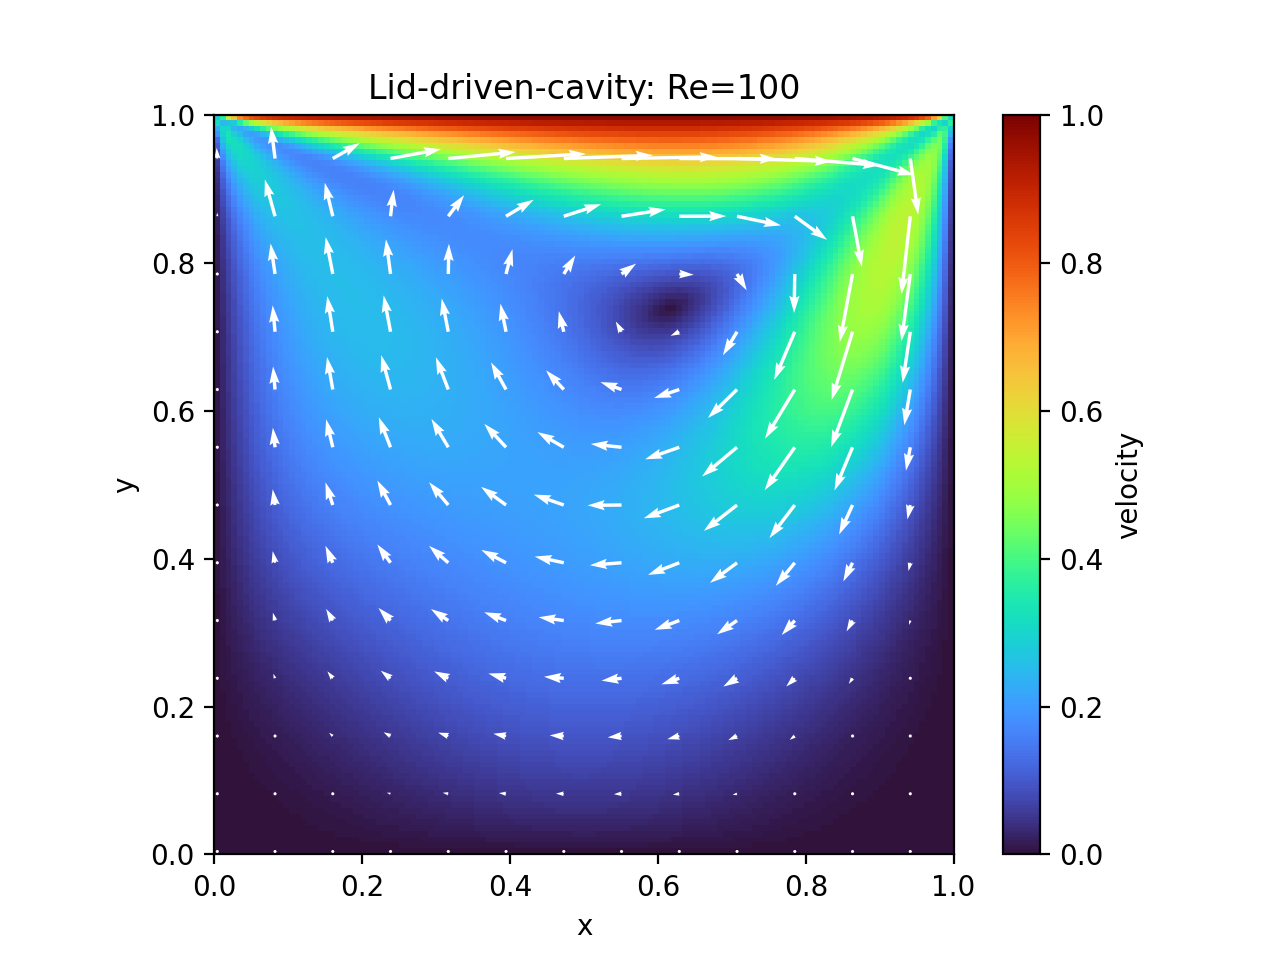

<IPython.core.display.Javascript object>


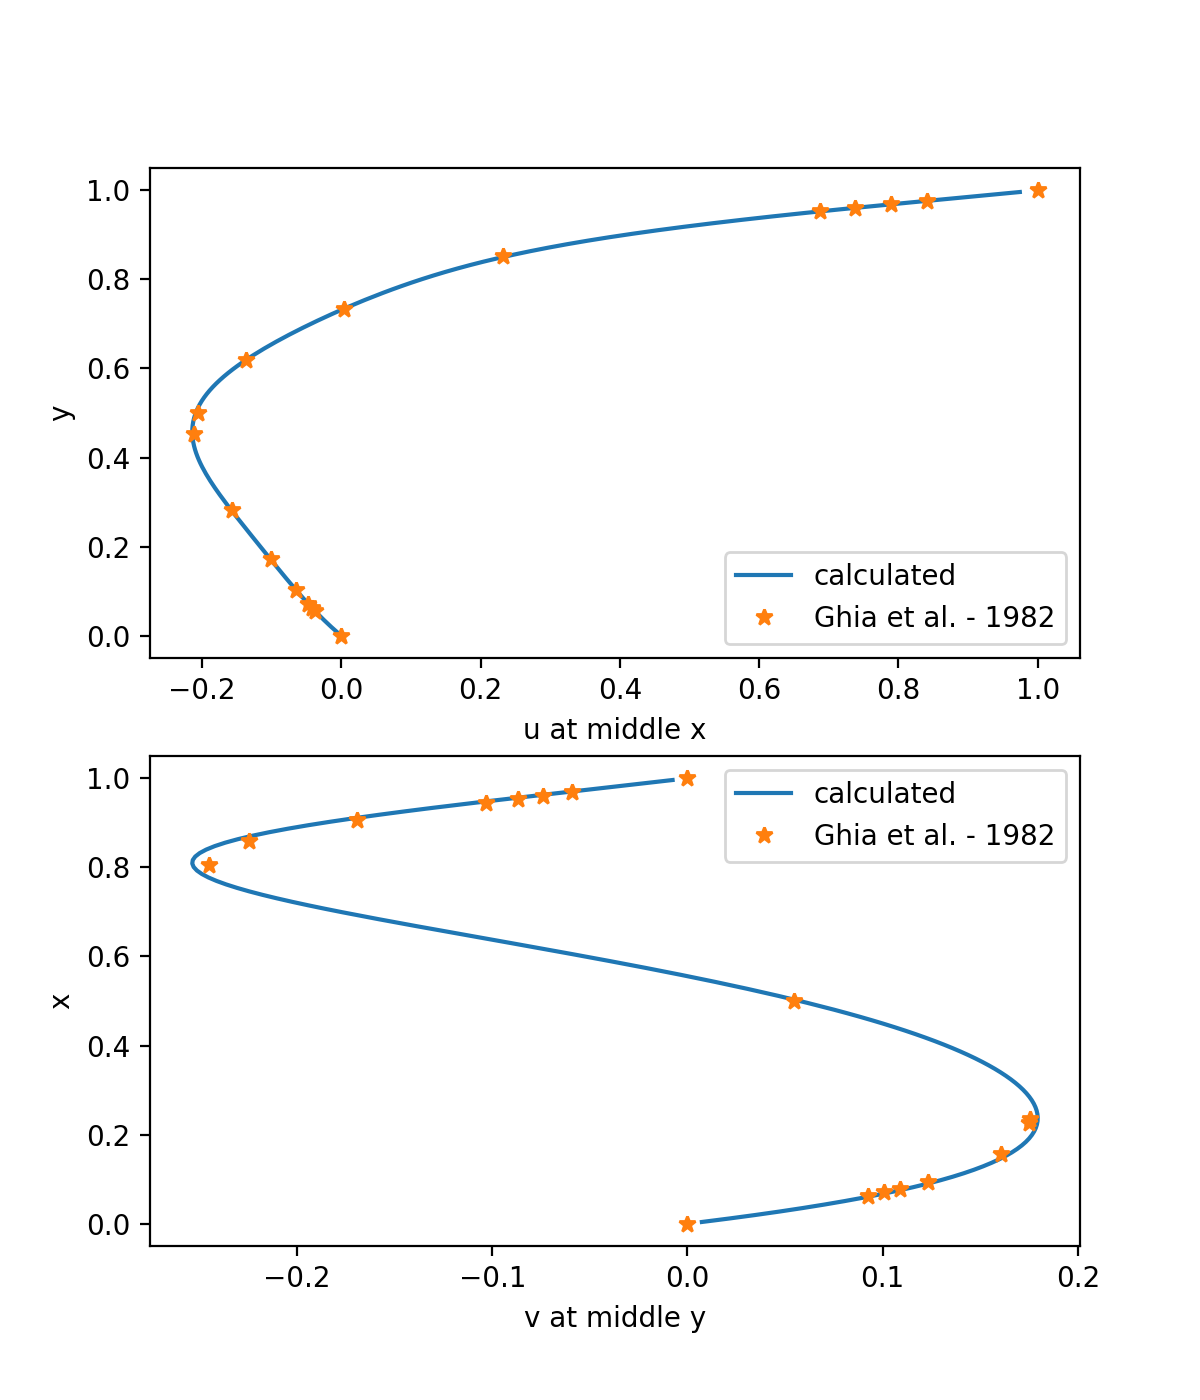

In [9]:
plot_lcd_contour(vel0,xc,yc,interval=10)

plot_lcd_compare(vel0,xc,yc,Re,legend='calculated')

In [13]:
### example 2: transient solver, implicit diffusion, explicit convection 
def compute_residual(vel,p,vel0,conv0):
    p_b = get_bound_values(p,[[1,1,1,1],[0,0,0,0]],dX)
    vel_b = get_bound_values(vel,BC_info,dX)
    
    res1 = ((vel-vel0)/dt*dX[0]*dX[1] + 
            conv0 - 
            diffusion(vel,vel_b,visco,dX) + 
            gradient(p,p_b,dX)*dX[0]*dX[1])
    
    u_f,v_f = get_face_values(vel,BC_info,dX)
    res2 = ((u_f[1:,:]-u_f[:-1,:])*dX[1] + (v_f[:,1:]-v_f[:,:-1])*dX[0])  
    
    return np.concatenate((res1.flatten(),res2.flatten()))

@jax.jit
def time_integration(vel0,conv0):
    def A_fn(f):
        vel = f[:Nx*Ny*2].reshape((Nx,Ny,-1))
        p = f[Nx*Ny*2:].reshape((Nx,Ny,-1))
        return compute_residual(vel,p,vel0,conv0)
    
    
    dofs = np.zeros(Nx*Ny*3)
    dofs,res = solver_linear(A_fn,dofs)
    
    # update vel
    vel = dofs[:Nx*Ny*2].reshape(Nx,Ny,-1)
    p = dofs[Nx*Ny*2:].reshape(Nx,Ny,-1)
    
    
    # calcualte convection for the next time step
    vel_b = get_bound_values(vel,BC_info,dX)
    vel_f = get_face_values(vel,BC_info,dX)
    conv = convection(vel,vel_b,vel_f,dX)
    
    # if norm(vel-vel0)<tol, steady
    steady = np.linalg.norm(vel-vel0)/np.linalg.norm(vel0) < 1e-5
    
    return vel,p,conv,res,steady

In [14]:
%%time
Re = 1000
visco = 1./Re
dt = 0.005
vel0 = np.zeros((Nx,Ny,2))
p0 = np.zeros((Nx,Ny,1))
vel0_b = get_bound_values(vel0,BC_info,dX)
vel0_f = get_face_values(vel0,BC_info,dX)
conv0 = convection(vel0,vel0_b,vel0_f,dX)
max_step = 10000

for i in range(0,max_step):
    vel0,p0,conv0,res,steady = time_integration(vel0,conv0)
    
    if res > 2e-5:
        print(f"res_norm = {res}, check the convergence!")
        break
        
    if i % 500 == 0:
        print(f"res_norm = {res}")
        
    if steady:
        print(f"reached steady state in {i+1} pseudo time step")
        break

res_norm = 9.99595820075367e-06
res_norm = 9.974389488555186e-06
res_norm = 9.910843642538382e-06
res_norm = 9.755679580532131e-06
res_norm = 9.968455809015782e-06
res_norm = 9.96478590685439e-06
res_norm = 9.9951400378535e-06
res_norm = 9.984539034699693e-06
res_norm = 9.66033103324049e-06
res_norm = 9.637899751790464e-06
res_norm = 9.96938433640637e-06
res_norm = 9.998915134870985e-06
res_norm = 9.54092345792591e-06
reached steady state in 6094 pseudo time step
CPU times: user 1min 26s, sys: 1.09 s, total: 1min 27s
Wall time: 1min 23s


<IPython.core.display.Javascript object>


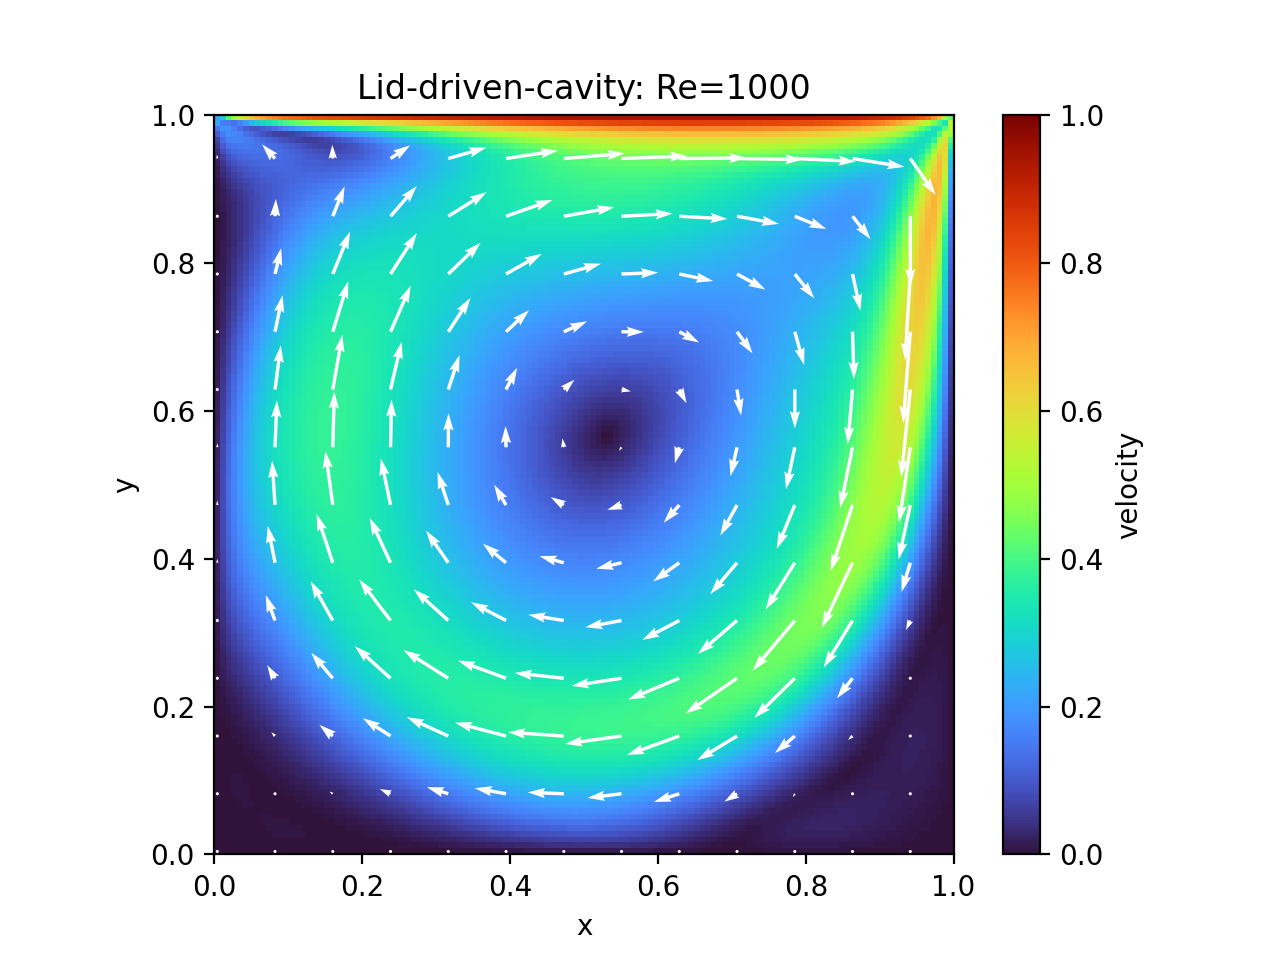

<IPython.core.display.Javascript object>


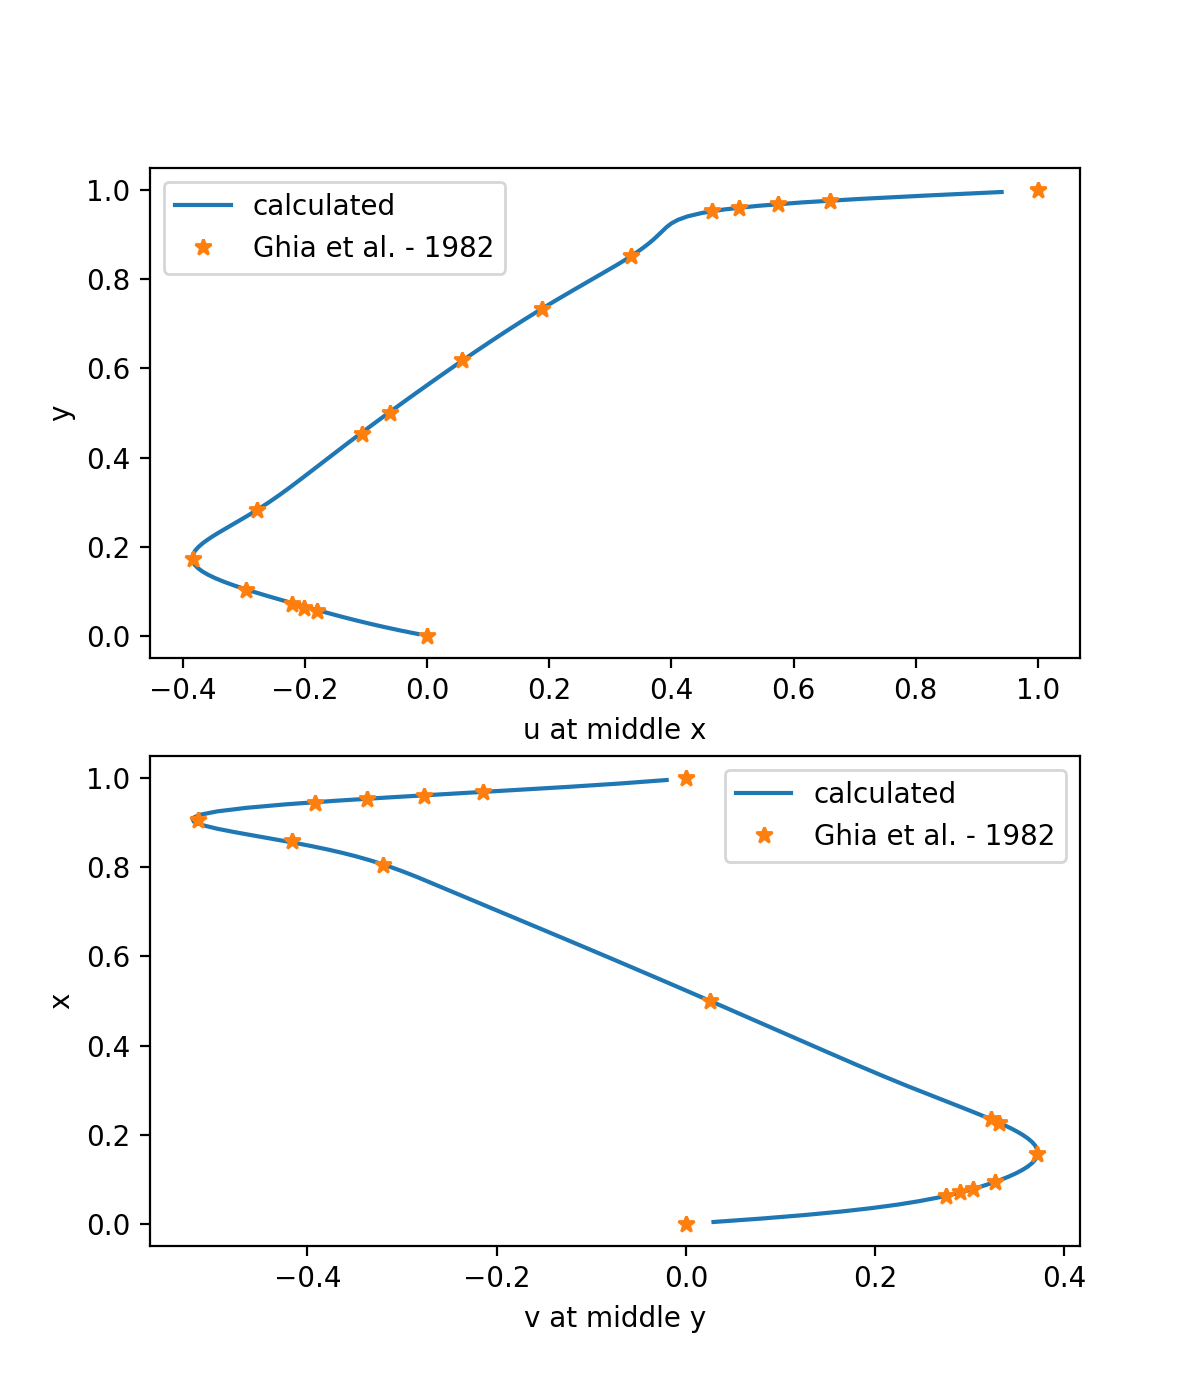

In [15]:
plot_lcd_contour(vel0,xc,yc,Re,interval=10)

plot_lcd_compare(vel0,xc,yc,Re,legend='calculated')